In [1]:
import pandas as pd
import os
import seaborn as sns
from riskyneuroarousal.utils.load_data import load_behavioral_data
import numpy as np
import matplotlib.pyplot as plt
%load_ext rpy2.ipython

For every subject, compute their dist_from_indiff


In [2]:
behavior = load_behavioral_data(min_RT = 0.2)
# prob_accept is 0 if response_int 1, 1/3 if response_int 2, 2/3 if response_int 3, 1 if response_int 4
behavior["prob_accept"] = behavior["response_int"].replace({1: 0, 2: 1/3, 3: 2/3, 4: 1})
sub_cond = behavior[["sub", "condition"]].drop_duplicates()

In [3]:
%%R -i behavior
library(lme4)
library(lmerTest)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [4]:
%%R
# for each subject, run acccept ~ gain + loss
# and save the coefficients
gain <- c()
loss <- c()
subs <- c()
for (i in unique(behavior$sub)) {
    sub_behavior = behavior[behavior$sub == i,]
    model = glm(accept ~ gain + loss, data = sub_behavior, family=binomial)
    gain <- c(gain, unname(coef(model)["gain"]))
    loss <- c(loss, unname(coef(model)["loss"]))
    subs <- c(subs, i)
}

In addition: There were 14 warnings (use warnings() to see them)


In [5]:
%%R -o indiff
indiff <- data.frame(sub = subs, gain = gain, loss = loss)

In [6]:
indiff["slope"] = np.abs(indiff["loss"] / indiff["gain"])
indiff = indiff.merge(sub_cond, on = "sub")

<Axes: xlabel='slope', ylabel='Count'>

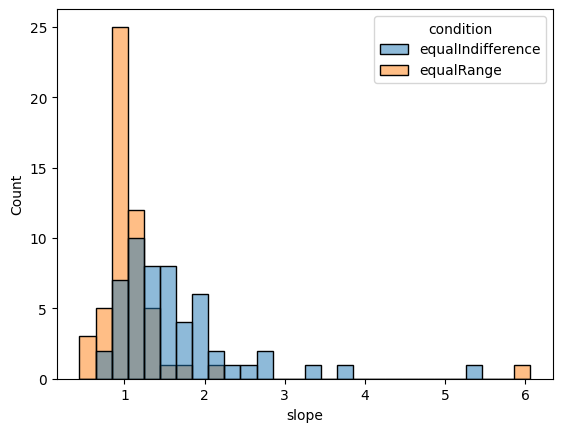

In [7]:
sns.histplot(x = "slope", hue = "condition", data = indiff)

In [8]:
behavior = behavior.merge(indiff[["sub", "slope"]], on = "sub")

In [9]:
behavior["dist_indiff"] = np.abs((behavior["gain"] - behavior["slope"] * behavior["loss"]) / np.sqrt(1 + behavior["slope"]**2))

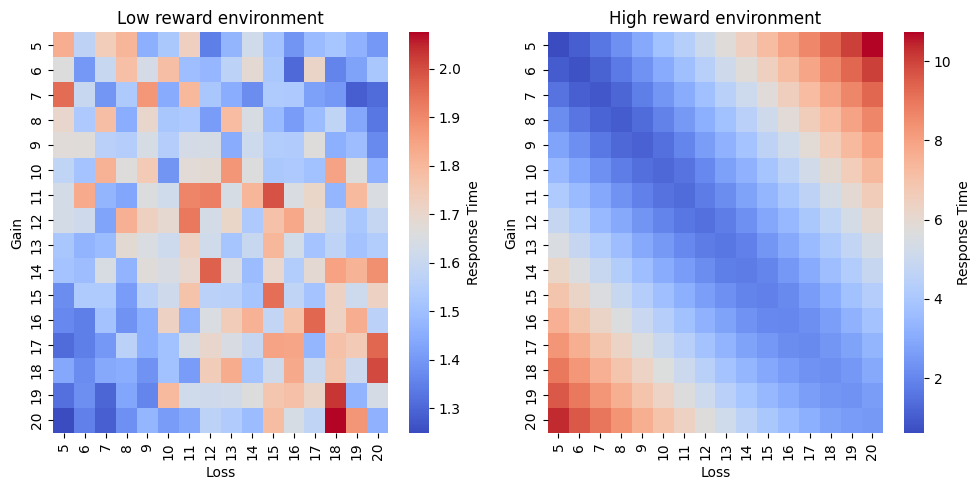

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = behavior.query("condition == 'equalRange'").groupby(['gain', 'loss'])['RT'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[0])
axs[0].set_title("Low reward environment")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = behavior.query("condition == 'equalRange'").groupby(['gain', 'loss'])['dist_indiff'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[1])
axs[1].set_title("High reward environment")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

In [11]:
# Load all the data
dir = "/Users/gustxsr/Documents/Stanford/PoldrackLab/PAPERS/paper1_loss_aversion_pupil/eye_data/NARPS_MG_asc_processed"
pupil_data = []

for file in os.listdir(dir):
    if file.endswith("baseline.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        pupil_data.append(csv)

pupil_data = pd.concat(pupil_data)
pupil_data = pupil_data.rename(columns={"trial_num": "trial"})
pupil_data = pupil_data.merge(behavior, on=["sub", "trial", "run"])

In [30]:
%%R -i pupil_data -o pupil_data
model2 <- lmer(RT ~ gain*condition + loss*condition + dist_indiff*condition + (1|sub), data=pupil_data)
pupil_data["residuals"] = resid(model2)

In [31]:
# for each sub, divide baseline into 4 bins
# and assign the bin number to each trial]
num_quantiles = 6
pupil_data['qbaseline'] = pupil_data.groupby('sub')['baseline'].transform(lambda x: pd.qcut(x, num_quantiles, labels=False))

In [36]:
new = pupil_data.groupby(['sub', 'qbaseline', 'condition'])['residuals'].mean().reset_index()
new['residuals'] = new['residuals']

<Axes: xlabel='qbaseline', ylabel='residuals'>

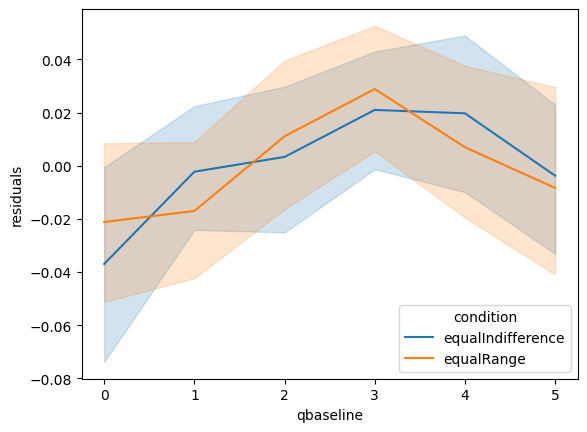

In [ ]:
sns.lineplot(x = "qbaseline", y = "residuals", hue = "condition", data = new)

In [22]:
%%R -i pupil_data
# make qbaseline a factor
pupil_data$qbaseline = as.factor(pupil_data$qbaseline)

In [23]:
%%R
# Is there an effect of accepting on response time between conditions? And if so, is this due to the gain and loss?
# Model 2: Predict Response Time as a function of condition, gain, loss, distance from indifference and response.
model3 <- lmer(RT ~ gain + loss + dist_indiff + qbaseline + (1|sub), data=pupil_data[pupil_data$condition == 'equalRange', ])
summary(model3)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + dist_indiff + qbaseline + (1 | sub)
   Data: pupil_data[pupil_data$condition == "equalRange", ]

REML criterion at convergence: 9200

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9209 -0.6590 -0.1471  0.5034  5.1620 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.09362  0.3060  
 Residual             0.21748  0.4663  
Number of obs: 6868, groups:  sub, 27

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  1.536e+00  6.441e-02  3.653e+01  23.850   <2e-16 ***
gain         1.530e-03  1.228e-03  6.833e+03   1.246   0.2128    
loss         1.071e-02  1.224e-03  6.833e+03   8.752   <2e-16 ***
dist_indiff -3.620e-02  1.890e-03  6.841e+03 -19.147   <2e-16 ***
qbaseline1   4.160e-03  1.951e-02  6.833e+03   0.213   0.8312    
qbaseline2   3.241e-02  1.944e-02  6.833e+03   1.668   0.0955 . 

In [26]:
pupil_data

,baseline,trial,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,prob_accept,slope,dist_indiff,qbaseline
0,0.095570,65,47,2,equalIndifference,40,5,1.443,1,4.0,strongly_accept,1.000000,1.102664,23.167509,3
1,-0.299883,66,47,2,equalIndifference,38,18,2.369,1,3.0,weakly_accept,0.666667,1.102664,12.194204,2
2,-0.624414,67,47,2,equalIndifference,22,16,1.647,1,3.0,weakly_accept,0.666667,1.102664,2.927200,1
3,-0.944491,68,47,2,equalIndifference,18,6,1.852,1,3.0,weakly_accept,0.666667,1.102664,7.647569,0
4,-0.912235,69,47,2,equalIndifference,34,7,1.442,1,4.0,strongly_accept,1.000000,1.102664,17.655322,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13983,-0.309530,124,5,2,equalIndifference,24,20,1.248,0,1.0,strongly_reject,0.000000,2.699390,10.417262,2
13984,-0.407138,125,5,2,equalIndifference,12,14,1.038,0,1.0,strongly_reject,0.000000,2.699390,8.959524,2
13985,-0.527832,126,5,2,equalIndifference,30,12,1.561,1,3.0,weakly_accept,0.666667,2.699390,0.831176,1
13986,-0.627627,127,5,2,equalIndifference,34,15,1.352,1,3.0,weakly_accept,0.666667,2.699390,2.254812,1


In [25]:
%%R 
# Is there an effect of accepting on response time between conditions? And if so, is this due to the gain and loss?
# Model 2: Predict Response Time as a function of condition, gain, loss, distance from indifference and response.
model4 <- lmer(RT ~ gain + loss + dist_indiff + qbaseline + (1|sub), data=pupil_data[pupil_data$condition == 'equalIndifference', ])
summary(model4)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + dist_indiff + qbaseline + (1 | sub)
   Data: pupil_data[pupil_data$condition == "equalIndifference", ]

REML criterion at convergence: 10488.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9913 -0.6667 -0.1506  0.4855  5.2923 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.07824  0.2797  
 Residual             0.24889  0.4989  
Number of obs: 7120, groups:  sub, 28

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  1.671e+00  5.943e-02  4.206e+01  28.115  < 2e-16 ***
gain         7.052e-03  8.258e-04  7.104e+03   8.539  < 2e-16 ***
loss         7.416e-03  1.362e-03  7.091e+03   5.447 5.31e-08 ***
dist_indiff -3.882e-02  1.498e-03  7.110e+03 -25.917  < 2e-16 ***
qbaseline1   3.457e-02  2.049e-02  7.084e+03   1.687  0.09160 .  
qbaseline2   4.008e-02  2.041e-02  7.084e+03   1.963  

In [154]:
residuals3

array([ 0.23441533, -0.77382509, -0.24970929, ..., -0.11540014,
       -0.47507455, -0.48901478], shape=(6868,))

In [153]:
pupil_data["residuals"] = np.nan

pupil_data[pupil_data["condition"] == "equalRange", "residuals"] = residuals3
pupil_data[pupil_data["condition"] == "equalIndifference", "residuals"] = residuals4

ValueError: Length of values (6868) does not match length of index (13988)